### Climate skill at 1&deg;: zonal- and time-means

In [1]:
from typing import List
from collections import namedtuple
from string import ascii_lowercase

import xarray as xr
from matplotlib import pyplot as plt
import matplotlib as mpl
from cartopy import crs as ccrs

from utils import get_beaker_dataset_variables, savefig, FONTSIZE, DPI
from constants import INFERENCE_COMPARISON_1DEG, WANDB_ENTITY, SECONDS_PER_DAY, WANDB_PROJECT

In [2]:
EvalVar = namedtuple("EvalVar", ("name", "long_name", "units", "conversion_factor", "error_scale"))

In [3]:
EVAL_VARS = [
    EvalVar("PRATEsfc", 'surface precipitation', 'mm/day', SECONDS_PER_DAY, 3.0),
    EvalVar("TMP2m", "2-meter air temperature", "K", None, 2.0),
    EvalVar("UGRD10m", "10m zonal wind speed", "m/s", None, 1.0)
]

DS_VARS = [
    f'gen_map-{var.name}' for var in EVAL_VARS
] + [
    f'bias_map-{var.name}' for var in EVAL_VARS]

In [4]:
# don't try to load climSST in this context
del INFERENCE_COMPARISON_1DEG['10yr']['ACE-climSST']
del INFERENCE_COMPARISON_1DEG['81yr']['ACE-climSST']

In [5]:
time_mean_datasets = []
for duration_name, duration_runs in INFERENCE_COMPARISON_1DEG.items():
    for source_name, source_runs in duration_runs.items():
        for ic_name, ic_run in source_runs.items():
            if '-' in ic_name:
                ic_name = ic_name.split("-")[1]
            full_key = '/'.join([duration_name, source_name, ic_name])
            print(f"Getting run: {full_key=}")
            ic_dataset = get_beaker_dataset_variables(ic_run, 'time_mean_diagnostics.nc', DS_VARS)
            for var in EVAL_VARS:
                if var.conversion_factor is not None:
                    ic_dataset[f"gen_map-{var.name}"] = (
                        var.conversion_factor * ic_dataset[f"gen_map-{var.name}"]
                    )
                    ic_dataset[f"bias_map-{var.name}"] = (
                        var.conversion_factor * ic_dataset[f"bias_map-{var.name}"]
                    )
                ic_dataset[f"target_map-{var.name}"] = (
                    ic_dataset[f"gen_map-{var.name}"] - ic_dataset[f"bias_map-{var.name}"]
                )
            time_mean_datasets.append(
                ic_dataset
                .to_array(dim='variable_name', name=source_name)
                .expand_dims({'duration': [duration_name], 'IC': [ic_name]})
            )
time_mean_ds = xr.merge(time_mean_datasets)

Downloading ⠴ 0:00:01 66.8 MB/s 30.3 MB

In [6]:
zonal_ic_mean = time_mean_ds.mean(dim=['lon', 'IC']).to_array(dim='source').to_dataset(dim='variable_name')
ic_mean = time_mean_ds.mean(dim=['IC']).to_array(dim='source').to_dataset(dim='variable_name')

In [7]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rc('font', size=FONTSIZE)
plt.rc('axes', titlesize=FONTSIZE)
plt.rc('axes', labelsize=(FONTSIZE - 2))
plt.rc('xtick', labelsize=(FONTSIZE - 4))
plt.rc('ytick', labelsize=(FONTSIZE - 4))
plt.rc('figure', dpi=DPI)

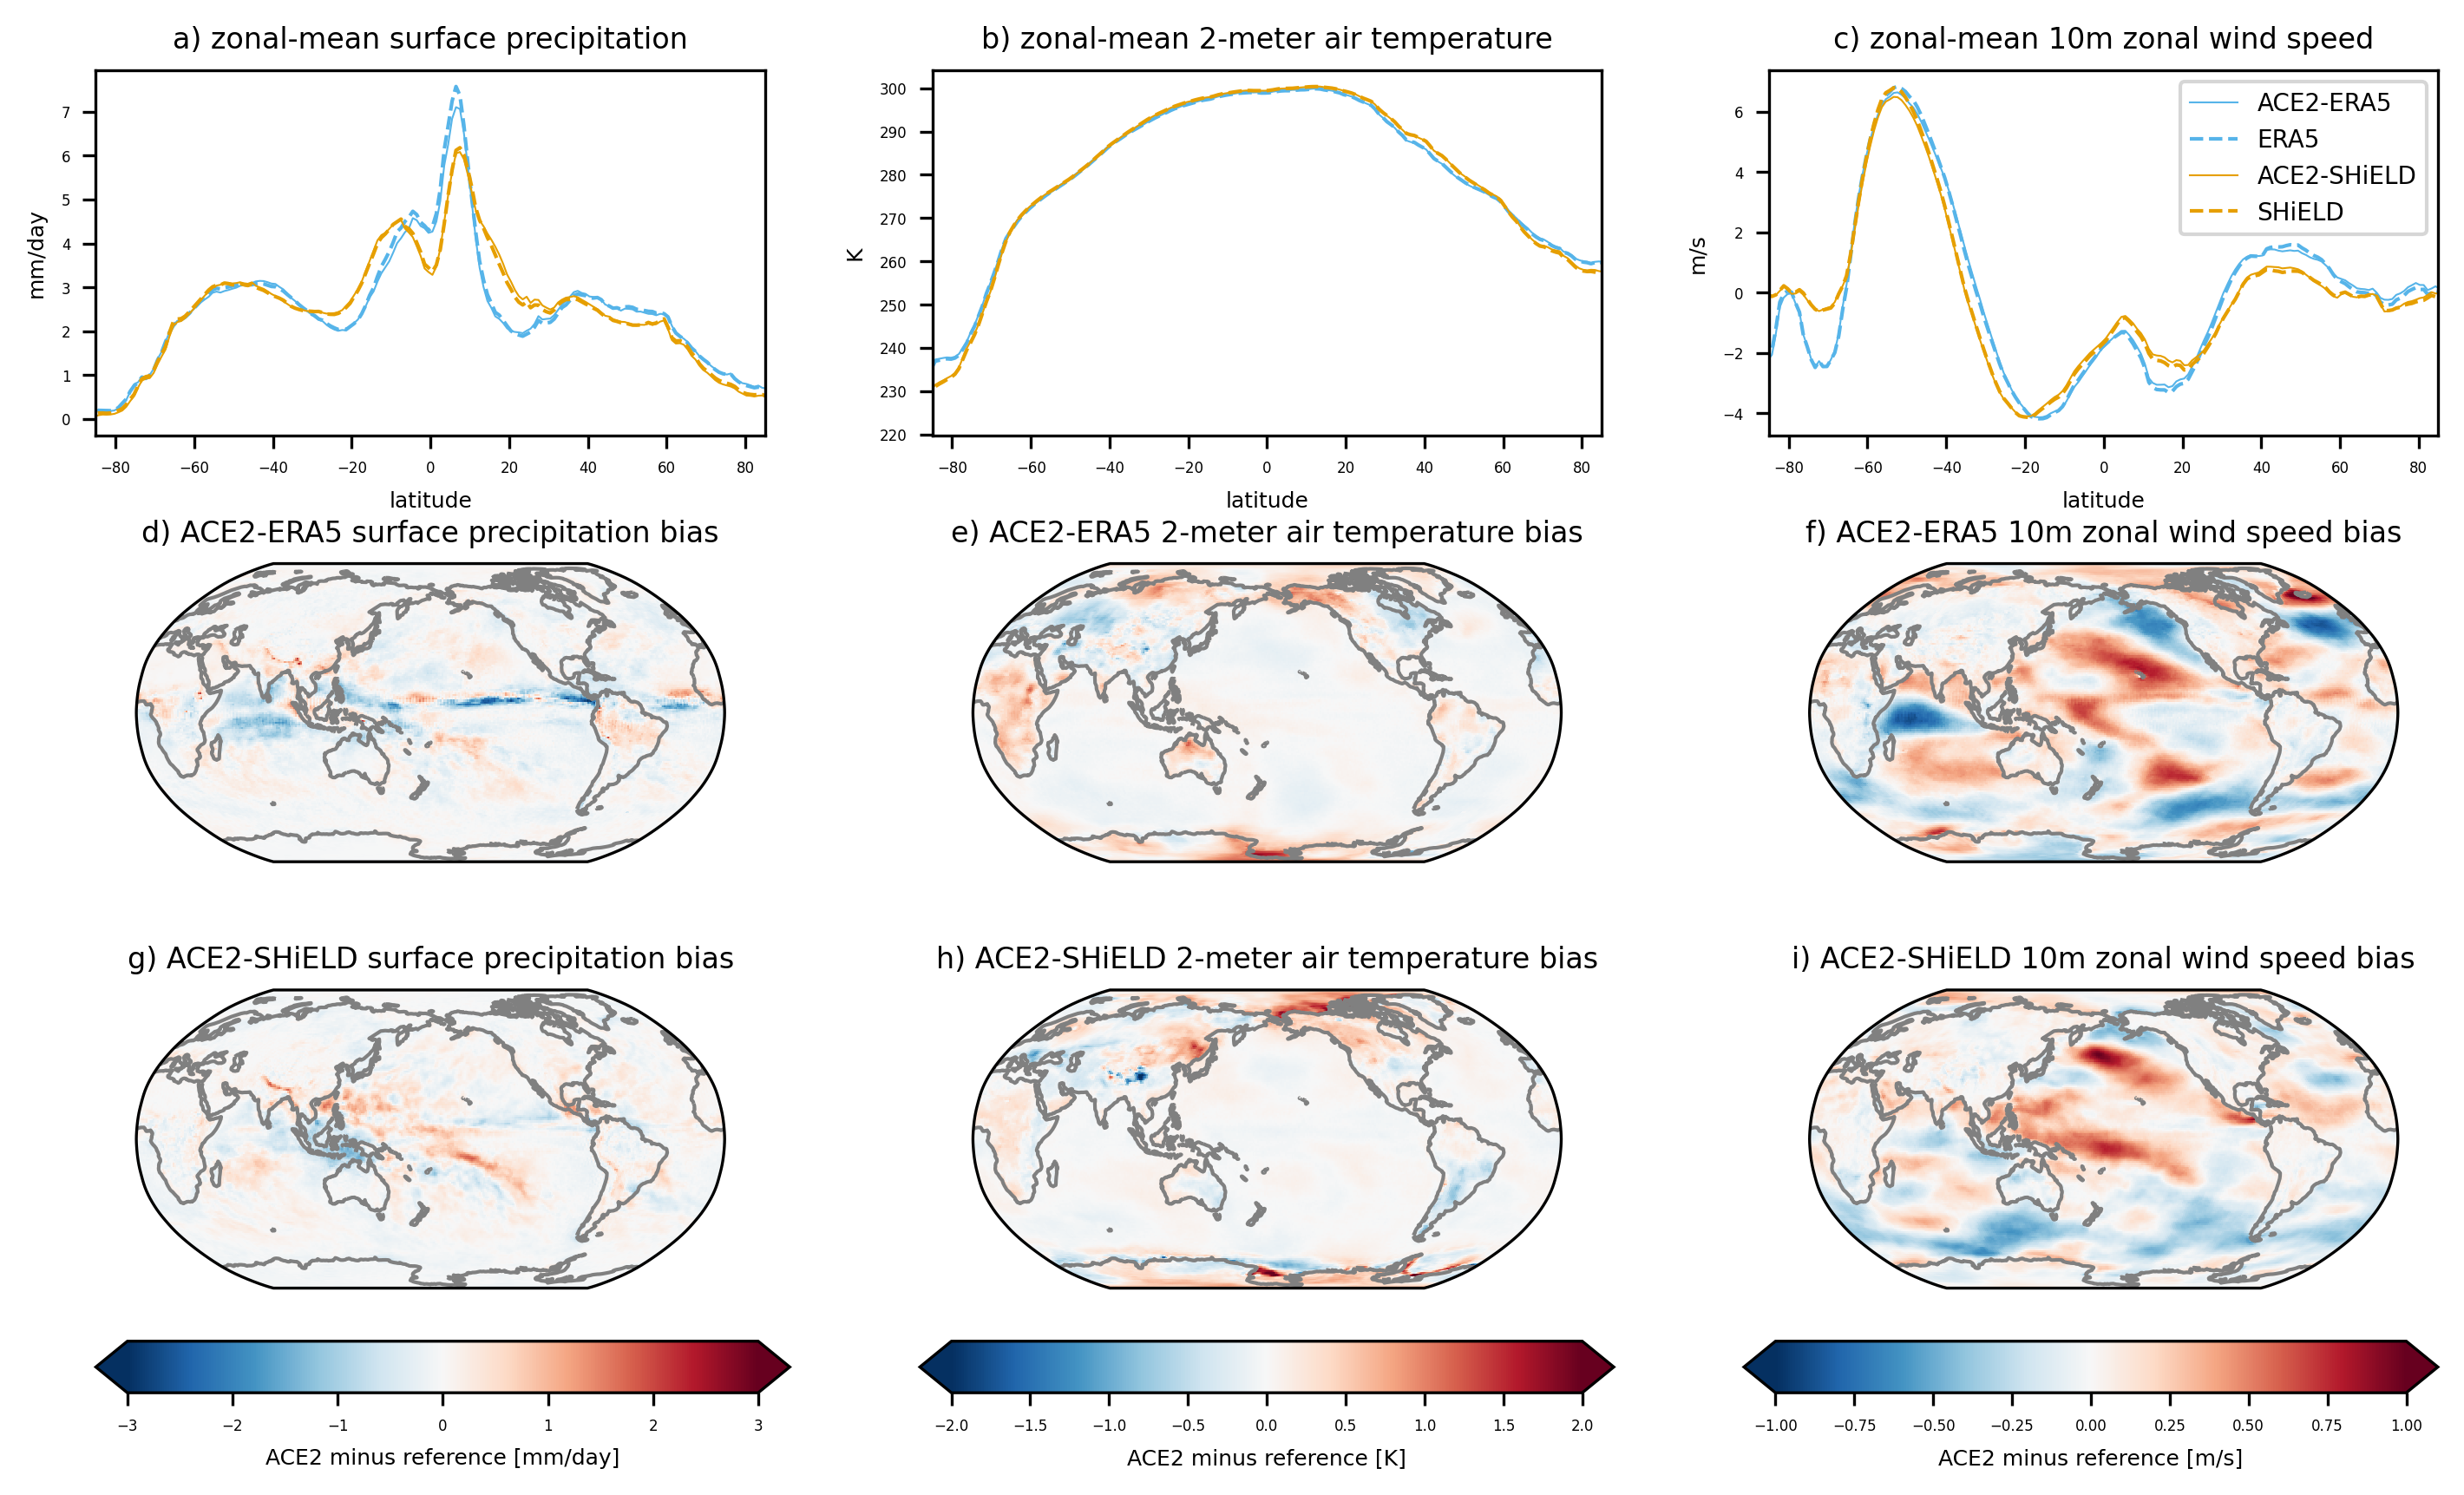

In [9]:
nrows, ncols = len(EVAL_VARS), 3 # for each variable, show: zonal mean lines, ERA5 bias map, AMIP bias map
fig, axes = plt.subplots(nrows, ncols, figsize=[10, 6], gridspec_kw=dict(bottom=0.10, right=0.95, left=0.05, hspace=0.4, wspace=0.25, height_ratios=[0.38, 0.31, 0.31]))
for ivar, var in enumerate(EVAL_VARS):
    # zonal mean
    iax0 = ivar
    ax0 = plt.subplot(nrows, ncols, iax0 + 1)
    zonal_ic_mean[f'gen_map-{var.name}'].sel(duration='10yr', source='ACE2-ERA5').plot(
        ax=ax0, color=colors[0], label='ACE2-ERA5', lw=0.5
    )
    zonal_ic_mean[f'target_map-{var.name}'].sel(duration='10yr', source='ACE2-ERA5').plot(
        ax=ax0, color=colors[0], ls='--', label='ERA5', lw=1
    )
    zonal_ic_mean[f'gen_map-{var.name}'].sel(duration='10yr', source='ACE2-SHiELD').plot(
        ax=ax0, color=colors[1], label='ACE2-SHiELD', lw=0.5
    )
    zonal_ic_mean[f'target_map-{var.name}'].sel(duration='10yr', source='ACE2-SHiELD').plot(
        ax=ax0, color=colors[1], ls='--', label='SHiELD', lw=1
    )
    ax0.set_title(f"{ascii_lowercase[iax0]}) zonal-mean {var.long_name}")
    ax0.set_xlim([-85, 85])
    ax0.set_ylabel(f"{var.units}")
    ax0.set_xlabel("latitude")
    if ivar == ncols - 1:
        ax0.legend(fontsize='small')
    # ACE2-ERA5 bias map
    plot_kwargs = dict(
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        vmin=-var.error_scale,
        vmax=var.error_scale,
        cmap='RdBu_r'
    )
    iax1 = ivar + 3
    axes[1, ivar].set_axis_off()
    ax1 = plt.subplot(nrows, ncols, iax1 + 1, projection=ccrs.Robinson(central_longitude=180))
    ax1.coastlines(color=[0.5, 0.5, 0.5])
    he = ic_mean[f'bias_map-{var.name}'].sel(duration='10yr', source='ACE2-ERA5').plot(ax=ax1, **plot_kwargs)
    ax1.set_title(f"{ascii_lowercase[iax1]}) ACE2-ERA5 {var.long_name} bias")
    # ACE2-SHiELD bias map
    iax2 = ivar + 6
    axes[2, ivar].set_axis_off()
    ax2 = plt.subplot(nrows, ncols, iax2 + 1, projection=ccrs.Robinson(central_longitude=180))
    ax2.coastlines(color=[0.5, 0.5, 0.5])
    ha = ic_mean[f'bias_map-{var.name}'].sel(duration='10yr', source='ACE2-SHiELD').plot(ax=ax2, **plot_kwargs)
    ax2.set_title(f"{ascii_lowercase[iax2]}) ACE2-SHiELD {var.long_name} bias")
    # colorbar
    cbar_ax = fig.add_axes([ivar * 0.3166 + 0.05, 0.033, 0.2666, 0.033])
    clabel = f"ACE2 minus reference [{var.units}]"
    fig.colorbar(he, cax=cbar_ax, extend='both', orientation='horizontal', label=clabel)
savefig(fig, 'climate_skill_1deg_zonal_time_mean.png')